http://seananderson.ca/2013/10/19/reshape.html

# Tabular Data Gym 2. Reshaping.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(magrittr)
library(ggplot2)
library(dplyr)
library(reshape2)

In [5]:
%%R
names(airquality) <- tolower(names(airquality))
head(airquality)

  ozone solar.r wind temp month day
1    41     190  7.4   67     5   1
2    36     118  8.0   72     5   2
3    12     149 12.6   74     5   3
4    18     313 11.5   62     5   4
5    NA      NA 14.3   56     5   5
6    28      NA 14.9   66     5   6


In [6]:
aq_pd = %R airquality
aq_pd.head()

,ozone,solar.r,wind,temp,month,day
1,41,190,7.4,67,5,1
2,36,118,8.0,72,5,2
3,12,149,12.6,74,5,3
4,18,313,11.5,62,5,4
5,-2147483648,-2147483648,14.3,56,5,5


Since `rpy2` does not treat NA well, we need to change it manually to `np.nan`.

In [7]:
def fix_nans_in_df(colname, df):
    df.ix[df[colname] < 0, colname] = np.NaN    

for colname in aq_pd.columns.values:
    fix_nans_in_df(colname, aq_pd)

aq_pd.head()

,ozone,solar.r,wind,temp,month,day
1,41.0,190.0,7.4,67.0,5.0,1.0
2,36.0,118.0,8.0,72.0,5.0,2.0
3,12.0,149.0,12.6,74.0,5.0,3.0
4,18.0,313.0,11.5,62.0,5.0,4.0
5,NaN,NaN,14.3,56.0,5.0,5.0


## Melt/stack: changing wide format into long

R function `melt` from `reshape2` package change wide fromat into long. 

In [9]:
%%R

aql <- melt(airquality)
aql %>% head

  variable value
1    ozone    41
2    ozone    36
3    ozone    12
4    ozone    18
5    ozone    NA
6    ozone    28


### Question 1

One can get similar result using pandas' method `melt`. 

In [11]:
pd.melt(aq_pd).head()

,variable,value
0,ozone,41.0
1,ozone,36.0
2,ozone,12.0
3,ozone,18.0
4,ozone,NaN


### Question 2

In [ ]:
%%R
airquality %>%
    melt(id.vars = c("month", "day")) %>%
    head()

Now let's try to get it with pandas.

In [14]:
pd.melt(aq_pd, id_vars=['month', 'day']).head()

,month,day,variable,value
0,5.0,1.0,ozone,41.0
1,5.0,2.0,ozone,36.0
2,5.0,3.0,ozone,12.0
3,5.0,4.0,ozone,18.0
4,5.0,5.0,ozone,NaN


## Question 3 Putting names to columns

In [15]:
%%R

aql <-
  melt(airquality, id.vars = c("month", "day"),
  variable.name = "climate_variable", 
  value.name = "climate_value") %>%
  mutate(date=as.Date(paste0("2015-",month,'-',day)))
head(aql)

  month day climate_variable climate_value       date
1     5   1            ozone            41 2015-05-01
2     5   2            ozone            36 2015-05-02
3     5   3            ozone            12 2015-05-03
4     5   4            ozone            18 2015-05-04
5     5   5            ozone            NA 2015-05-05
6     5   6            ozone            28 2015-05-06


Your turn with pandas.

In [29]:
aql2_pd = \
    pd.melt(
        aq_pd, id_vars = ["month", "day"], 
        var_name = "climate_variable", 
        value_name = "climate_value")

aql2_pd['date'] = ('2015-'+aql2_pd['month'].astype(int).astype(str)+'-'+aql2_pd['day'].astype(int).astype(str))

aql2_pd.head()

,month,day,climate_variable,climate_value,date
0,5.0,1.0,ozone,41.0,2015-5-1
1,5.0,2.0,ozone,36.0,2015-5-2
2,5.0,3.0,ozone,12.0,2015-5-3
3,5.0,4.0,ozone,18.0,2015-5-4
4,5.0,5.0,ozone,NaN,2015-5-5


### Comments about ploting

When one uses ggplot it is natural to use long format when ploting.

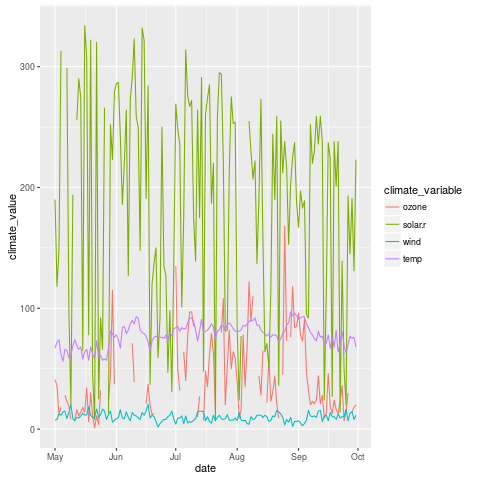

In [30]:
%%R
aql %>%
  ggplot() +
  geom_line(aes(date, climate_value, colour=climate_variable))

But with pandas' mathplotlib interface it is easier to use wild format.

First let's create dates.

In [31]:
aq_pd2= aq_pd.copy()

aq_pd2['date'] = \
    [pd.Timestamp(s) 
     for s in ('2015-'+aq_pd['month'].astype(int).astype(str)+'-'
               +aq_pd['day'].astype(int).astype(str))]

Then selecting columns and adding aproprite index one get: 

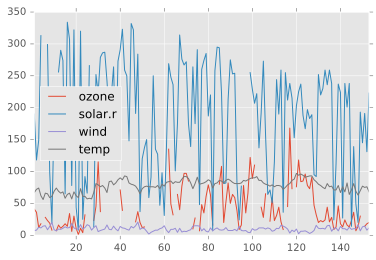

In [32]:
aq_pd2_indexed = aq_pd2[['date', 'ozone', 'solar.r', 'wind', 'temp']]
aq_pd2_indexed.set_index('date')
aq_pd2_indexed.plot()

### Question 4. Time for dcast

In [37]:
%%R
aqw <- dcast(aql, month + day ~ variable)
head(aqw)

  month day ozone solar.r wind temp
1     5   1    41     190  7.4   67
2     5   2    36     118  8.0   72
3     5   3    12     149 12.6   74
4     5   4    18     313 11.5   62
5     5   5    NA      NA 14.3   56
6     5   6    28      NA 14.9   66


The approprite pandas method seems to be `pivot_table`. Can you try?

In [39]:
aql_pd = pd.melt(aq_pd, id_vars=['month', 'day'])
aql_pd.head()

,month,day,variable,value
0,5.0,1.0,ozone,41.0
1,5.0,2.0,ozone,36.0
2,5.0,3.0,ozone,12.0
3,5.0,4.0,ozone,18.0
4,5.0,5.0,ozone,NaN


In [48]:
aql_pd.pivot_table(index=["month", "day"], columns="variable", values="value").reset_index(1).reset_index(1)

variable,month,day,ozone,solar.r,temp,wind
0,5.0,1.0,41.0,190.0,67.0,7.4
1,5.0,2.0,36.0,118.0,72.0,8.0
2,5.0,3.0,12.0,149.0,74.0,12.6
3,5.0,4.0,18.0,313.0,62.0,11.5
4,5.0,5.0,NaN,NaN,56.0,14.3
5,5.0,6.0,28.0,NaN,66.0,14.9
6,5.0,7.0,23.0,299.0,65.0,8.6
7,5.0,8.0,19.0,99.0,59.0,13.8
8,5.0,9.0,8.0,19.0,61.0,20.1
9,5.0,10.0,NaN,194.0,69.0,8.6


### Question 5. Melting with stack

There is another pandas' method for maelting. It is called stack. Can you try it with `aq_pd`? What is the type of the result? Can you make it to be DataFrame with comlumns `varaiable` and `value`?

### Question 6. Melt, filter, group, agregate.

In [ ]:
%%R
aql %>% head

In [ ]:
%%R
airquality %>%
    melt(id.vars = c("month", "day")) %>%
    filter(!is.na(value)) %>%
    group_by(variable) %>%
    summarize(total= sum(value))  

In [ ]:
%%R
library(data.table)
data.table(airquality) %>%
    melt(id.vars = c("month", "day")) %>%
    .[!is.na(value), .(total=sum(value)), by=variable]

Time for doing this with pands: